In [76]:
!pip install yfinance ta matplotlib pandas  selenium undetected_chromedriver fpdf --quiet

  Preparing metadata (setup.py) ... done


In [122]:
import yfinance as yf
import requests
from urllib.parse import quote
from bs4 import BeautifulSoup
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import datetime, timedelta
import ta
import textwrap

In [ ]:
 # Make sure pandas is imported if you intend to use display()

def generate_report(df):
    for ticker in df:
        stock_information = yf.download(ticker, start="2024-01-01", end="2025-05-22")
        if not stock_information.empty:
            stock_information['EMA_20'] = stock_information['Close'].rolling(window=20).mean()
            stock_information['EMA_50'] = stock_information['Close'].rolling(window=50).mean()

            # Rsi Indicator
            rsi_indicator = ta.momentum.RSIIndicator(close=stock_information['Close'].squeeze(), window=14)
            stock_information['RSI'] = rsi_indicator.rsi()

            # MACD indicator
            MACD_indicator = ta.trend.MACD(close=stock_information['Close'].squeeze(), window_slow=26, window_fast=12, window_sign=9)
            stock_information['MACD'] = MACD_indicator.macd()
            stock_information['MACD_signal'] = MACD_indicator.macd_signal()
            stock_information['MACD_histogram'] = MACD_indicator.macd_diff()


            plt.figure(figsize=(20, 10))

            # Plotting the Close Price and Moving Averages
            plt.subplot(2, 2, 1)
            plt.plot(stock_information['Close'], label='Close Price', color='black')
            plt.plot(stock_information['EMA_20'], label='20-Week EMA', color='blue')  # Corrected label
            plt.plot(stock_information['EMA_50'], label='50-Week EMA', color='orange')  # Corrected label
            plt.title(f'{ticker} Stock Price with Exponential Moving Averages')  # Dynamic title
            plt.legend()

            # Plotting the MACD
            plt.subplot(2, 2, 2)
            plt.plot(stock_information['MACD'], label='MACD', color='green')
            plt.plot(stock_information['MACD_signal'], label='MACD Signal', color='red')
            plt.title(f'{ticker} MACD')  # Dynamic title
            plt.legend()

            # Plotting the RSI
            plt.subplot(2, 2, 3)
            plt.plot(stock_information['RSI'], label='RSI', color='purple')
            plt.axhline(70, color='red', linestyle='--')
            plt.axhline(30, color='green', linestyle='--')
            plt.title(f'{ticker} RSI (Relative Strength Index)')  # Dynamic title
            plt.legend()

            # Final adjustment to avoid overlap
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not download data for: {ticker}")


[*********************100%***********************]  1 of 1 completed


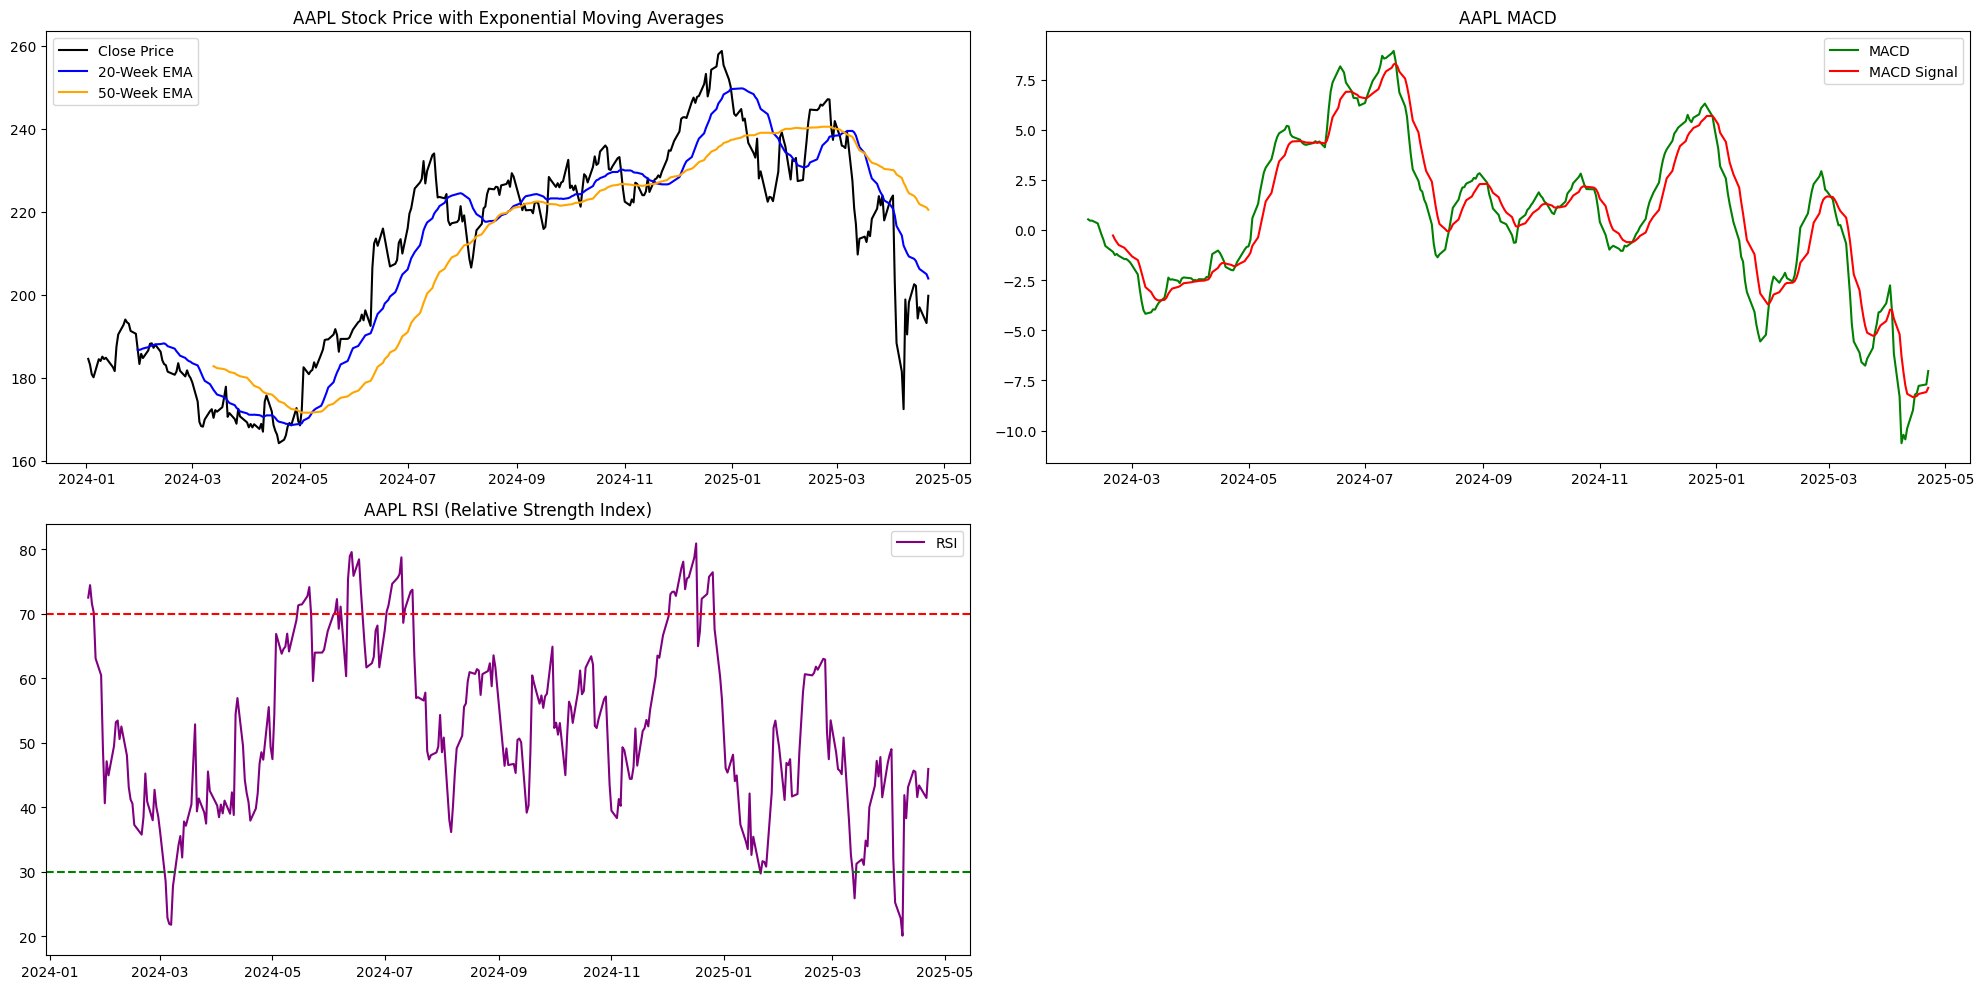

In [ ]:
df=["AAPL"]
generate_report(df)

In [59]:
import json
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import pandas as pd
from urllib.parse import quote

def getNewsData(ticker, max_results=5):  # Add a parameter to control the number of results
    company = yf.Ticker(ticker)
    company_name = company.info.get('longName', ticker)
    query = f"{company_name} stock news"

    headers = {
        "User-Agent":
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
    }
    response = requests.get(
        f"https://www.google.com/search?q={quote(query)}&hl=us&tbm=nws&num=100", headers=headers
    )
    print(query)
    soup = BeautifulSoup(response.content, "html.parser")
    news_results = []

    for data in soup.select("div.SoaBEf"):
        news_results.append(
            {
                "link": data.find("a")["href"],
                "title": data.select_one("div.MBeuO").get_text(),
                "snippet": data.select_one(".GI74Re").get_text(),
                "date": data.select_one(".LfVVr").get_text(),
                "source": data.select_one(".NUnG9d span").get_text()
            }
        )
        if len(news_results) == max_results:  # Stop after collecting max_results
            break

    print(json.dumps(news_results, indent=2))

getNewsData("AAPL", max_results=5)  # Call with a limit of 5 results


Apple Inc. stock news
[
  {
    "link": "https://finance.yahoo.com/news/apple-inc-aapl-among-stocks-021614536.html",
    "title": "Apple Inc. (AAPL): Among Stocks That Could 10X Over the Next 2 Years",
    "snippet": "We recently published a list of 9 Stocks That Could 10X Over the Next 2 Years. In this article, we are going to take a look at where Apple...",
    "date": "1 day ago",
    "source": "Yahoo Finance"
  },
  {
    "link": "https://www.defenseworld.net/2025/04/23/apple-inc-nasdaqaapl-stock-position-decreased-by-ddd-partners-llc.html",
    "title": "Apple Inc. (NASDAQ:AAPL) Stock Position Decreased by DDD Partners LLC",
    "snippet": "Read Apple Inc. (NASDAQ:AAPL) Stock Position Decreased by DDD Partners LLC at Defense World.",
    "date": "6 hours ago",
    "source": "Defense World"
  },
  {
    "link": "https://finance.yahoo.com/news/apple-inc-aapl-best-metaverse-215536985.html",
    "title": "Is Apple Inc. (AAPL) the Best Metaverse Stock to Invest in?",
    "snippet": "We

In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import ta
from bs4 import BeautifulSoup
import requests
from urllib.parse import quote
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from matplotlib.gridspec import GridSpec

def generate_report(tickers):
    for ticker in tickers:
        # Create PDF for each ticker
        with PdfPages(f'{ticker}_Stock_Report.pdf') as pdf:
            plt.figure(figsize=(11, 8.5))  # Letter size
            plt.suptitle(f'Stock Analysis Report: {ticker}', fontsize=16, y=0.98)

            # Get stock data
            stock_data = yf.download(ticker, period="1y")

            if not stock_data.empty:
                # Calculate indicators
                stock_data['EMA_20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
                stock_data['EMA_50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()

                # Create grid layout
                gs = GridSpec(3, 1, height_ratios=[1.5, 1, 1.5], hspace=0.5)

                # Chart 1: Price with EMAs (top half)
                ax1 = plt.subplot(gs[0])
                ax1.plot(stock_data['Close'], label='Close Price', color='#1f77b4', linewidth=2)
                ax1.plot(stock_data['EMA_20'], label='20-Day EMA', color='#ff7f0e', linestyle='--')
                ax1.plot(stock_data['EMA_50'], label='50-Day EMA', color='#2ca02c', linestyle='--')
                ax1.set_title('Price with Moving Averages', pad=10)
                ax1.legend(loc='upper left')
                ax1.grid(True, alpha=0.3)
                ax1.set_facecolor('#f8f8f8')

                # Get news data
                news_data = get_news(ticker)

                # News section (middle)
                ax2 = plt.subplot(gs[1])
                ax2.axis('off')
                news_text = "Latest News:\n\n"
                for i, news in enumerate(news_data[:3]):  # Show top 3 news
                    news_text += f"• {news['title']}\n"
                    news_text += f"  {news['source']} | {news['date']}\n\n"

                ax2.text(0, 1, news_text, ha='left', va='top', wrap=True,
                        fontsize=10, bbox=dict(facecolor='#f8f8f8', alpha=0.5))

                # LSTM Prediction (bottom)
                ax3 = plt.subplot(gs[2])
                dates, predictions = generate_lstm_prediction(ticker, days=30)
                ax3.plot(dates, predictions, 'r-', label='Predicted Price', linewidth=2)
                ax3.set_title(f'30-Day Price Prediction (as of {dates[0].strftime("%Y-%m-%d")})', pad=10)
                ax3.set_xlabel('Future Dates')
                ax3.set_ylabel('Price ($)')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                ax3.set_facecolor('#f8f8f8')
                plt.xticks(rotation=45)

                plt.tight_layout()
                pdf.savefig()
                plt.close()

                print(f"Successfully generated report for {ticker}")
            else:
                print(f"Could not download data for: {ticker}")

def get_news(ticker, max_results=5):  # Add a parameter to control the number of results
    company = yf.Ticker(ticker)
    company_name = company.info.get('longName', ticker)
    query = f"{company_name} stock news"

    headers = {
        "User-Agent":
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
    }
    response = requests.get(
        f"https://www.google.com/search?q={quote(query)}&hl=us&tbm=nws&num=100", headers=headers
    )
    print(query)
    soup = BeautifulSoup(response.content, "html.parser")
    news_results = []

    for data in soup.select("div.SoaBEf"):
        news_results.append(
            {
                "link": data.find("a")["href"],
                "title": data.select_one("div.MBeuO").get_text(),
                "snippet": data.select_one(".GI74Re").get_text(),
                "date": data.select_one(".LfVVr").get_text(),
                "source": data.select_one(".NUnG9d span").get_text()
            }
        )
        if len(news_results) == max_results:  # Stop after collecting max_results
            break

    return news_results


def generate_lstm_prediction(ticker, days=30):
    stock = yf.Ticker(ticker)
    df = stock.history(period='1y')
    dates = df.index
    last_date = dates[-1]
    data = df['Close'].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)

    X, y = [], []
    for i in range(60, len(data_normalized)):
        X.append(data_normalized[i-60:i, 0])
        y.append(data_normalized[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)),
        Dropout(0.2),
        LSTM(100),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=20, batch_size=32, verbose=0)

    last_sequence = data_normalized[-60:]
    predictions = []
    for _ in range(days):
        x = last_sequence[-60:].reshape(1, 60, 1)
        pred = model.predict(x, verbose=0)
        predictions.append(pred[0,0])
        last_sequence = np.append(last_sequence, pred)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    future_dates = [last_date + timedelta(days=i) for i in range(1, days+1)]

    return future_dates, predictions

if __name__ == "__main__":
    tickers = ["AAPL", "TSLA", "2330.TW"]
    generate_report(tickers)

[*********************100%***********************]  1 of 1 completed


Apple Inc. stock news


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-66-f431c2b3c468>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
[*********************100%***********************]  1 of 1 completed

Successfully generated report for AAPL


Tesla, Inc. stock news


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-66-f431c2b3c468>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Successfully generated report for TSLA


[*********************100%***********************]  1 of 1 completed


Taiwan Semiconductor Manufacturing Company Limited stock news


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-66-f431c2b3c468>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Successfully generated report for 2330.TW


In [63]:
import json
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import pandas as pd
from urllib.parse import quote

def getNewsData(ticker, max_results=5):  # Add a parameter to control the number of results
    company = yf.Ticker(ticker)
    company_name = company.info.get('longName', ticker)
    query = f"{company_name} stock news"

    headers = {
        "User-Agent":
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
    }
    response = requests.get(
        f"https://www.google.com/search?q={quote(query)}&hl=us&tbm=nws&num=100", headers=headers
    )
    print(query)
    soup = BeautifulSoup(response.content, "html.parser")
    news_results = []

    for data in soup.select("div.SoaBEf"):
        news_results.append(
            {
                "link": data.find("a")["href"],
                "title": data.select_one("div.MBeuO").get_text(),
                "snippet": data.select_one(".GI74Re").get_text(),
                "date": data.select_one(".LfVVr").get_text(),
                "source": data.select_one(".NUnG9d span").get_text()
            }
        )
        if len(news_results) == max_results:  # Stop after collecting max_results
            break

    return news_results




In [137]:
def get_news(ticker, max_results=5):
    try:
        company = yf.Ticker(ticker)
        company_name = company.info.get('longName', ticker)
        query = f"{company_name} stock news"

        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36"
        }

        response = requests.get(
            f"https://www.google.com/search?q={quote(query)}&hl=us&tbm=nws&num={max_results}",
            headers=headers,
            timeout=10
        )
        soup = BeautifulSoup(response.content, "html.parser")
        news_results = []

        for data in soup.select("div.SoaBEf")[:max_results]:
            try:
                news_results.append({
                    "link": data.find("a")["href"],
                    "title": data.select_one("div.MBeuO").get_text(),
                    "source": data.select_one(".NUnG9d span").get_text(),
                    "date": data.select_one(".LfVVr").get_text() if data.select_one(".LfVVr") else "N/A"
                })
            except Exception as e:
                print(f"⚠️ Error parsing news item: {str(e)}")
                continue

        return news_results
    except Exception as e:
        print(f" News scraping failed for {ticker}: {str(e)}")
        return [{"title": "News unavailable", "link": "#", "source": "Error", "date": "N/A"}]

def generate_lstm_prediction(ticker, days=7):
    try:
        # Get data with retry logic
        max_retries = 3
        df = None
        for attempt in range(max_retries):
            try:
                stock = yf.Ticker(ticker)
                df = stock.history(period='6mo')
                if len(df) < 60:
                    raise ValueError(f"Insufficient data ({len(df)} points). Need at least 60.")
                break
            except Exception as e:
                if attempt == max_retries - 1:
                    raise
                print(f"Retrying download for {ticker}...")

        dates = df.index
        last_date = dates[-1]
        data = df['Close'].values.reshape(-1, 1)

        # Data validation
        if np.isnan(data).any() or (data <= 0).any():
            raise ValueError("Invalid data points in closing prices")

        # Normalize data
        scaler = MinMaxScaler()
        data_normalized = scaler.fit_transform(data)

        # Create sequences with validation
        if len(data_normalized) < 60:
            raise ValueError("Not enough data for sequence creation")

        X, y = [], []
        for i in range(60, len(data_normalized)):
            X.append(data_normalized[i-60:i, 0])
            y.append(data_normalized[i, 0])

        X, y = np.array(X), np.array(y)
        if X.shape[0] == 0:
            raise ValueError("No valid sequences created")

        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        # Enhanced LSTM model
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)),
            Dropout(0.3),
            LSTM(50),
            Dropout(0.3),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X, y, epochs=50, batch_size=32, verbose=0)

        # Generate predictions
        last_sequence = data_normalized[-60:]
        predictions = []
        for _ in range(days):
            x = last_sequence[-60:].reshape(1, 60, 1)
            pred = model.predict(x, verbose=0)
            predictions.append(pred[0,0])
            last_sequence = np.append(last_sequence, pred)

        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        future_dates = [last_date + timedelta(days=i) for i in range(1, days+1)]

        return future_dates, predictions.flatten()

    except Exception as e:
        print(f" LSTM prediction failed for {ticker}: {str(e)}")
        # Return flat line prediction as fallback
        stock_data_fallback = yf.download(ticker, period="1d")
        last_price = stock_data_fallback['Close'].iloc[-1] if not stock_data_fallback.empty else 100
        return [datetime.now() + timedelta(days=i) for i in range(1, days+1)], np.full(days, last_price)

def generate_report(tickers):
    for ticker in tickers:
        with PdfPages(f'{ticker}_Stock_Report.pdf') as pdf:
            # Try downloading data with retries
            max_retries = 3
            stock_data = None
            for attempt in range(max_retries):
                try:
                    stock_data = yf.download(ticker, period="6mo")
                    if len(stock_data) < 30:  # Minimum days check
                        raise ValueError("Insufficient historical data")
                    break
                except Exception as e:
                    if attempt == max_retries - 1:
                        print(f" Could not download data for {ticker}: {str(e)}")
                        continue

            if stock_data is None or stock_data.empty:
                continue

            # Calculate indicators
            stock_data['EMA_20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
            stock_data['EMA_50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()
            stock_data['RSI'] = ta.momentum.RSIIndicator(stock_data['Close'].squeeze(), window=14).rsi()
            macd = ta.trend.MACD(stock_data['Close'].squeeze(), window_slow=26, window_fast=12, window_sign=9)
            stock_data['MACD'] = macd.macd()
            stock_data['MACD_signal'] = macd.macd_signal()
            stock_data['MACD_hist'] = macd.macd_diff()


            fig1 = plt.figure(figsize=(14, 10), facecolor='#f5f5f5')
            plt.suptitle(f'Stock Analysis Report: {ticker}', fontsize=16, y=0.98,
                         fontweight='bold', color='#2c3e50')

            gs1 = GridSpec(3, 1, height_ratios=[1.2, 0.8, 0.8], hspace=0.6)

            # Price and EMAs
            ax1 = plt.subplot(gs1[0])
            ax1.plot(stock_data['Close'], label='Close', color='#3498db', linewidth=2)
            ax1.plot(stock_data['EMA_20'], label='20-EMA', color='#e74c3c', linestyle='--', linewidth=1.5)
            ax1.plot(stock_data['EMA_50'], label='50-EMA', color='#2ecc71', linestyle='--', linewidth=1.5)
            ax1.set_title('Price & Moving Averages', fontsize=12, fontweight='bold')
            ax1.grid(True, alpha=0.3, linestyle=':')
            ax1.legend(loc='upper left', framealpha=0.7)
            ax1.set_facecolor('#ffffff')

            # RSI
            ax2 = plt.subplot(gs1[1])
            ax2.plot(stock_data['RSI'], color='#9b59b6', linewidth=1.5)
            ax2.axhline(70, color='#e74c3c', linestyle='--', alpha=0.7)
            ax2.axhline(30, color='#2ecc71', linestyle='--', alpha=0.7)
            ax2.fill_between(stock_data.index, 70, stock_data['RSI'],
                             where=stock_data['RSI']>70, color='#e74c3c', alpha=0.2)
            ax2.fill_between(stock_data.index, 30, stock_data['RSI'],
                             where=stock_data['RSI']<30, color='#2ecc71', alpha=0.2)
            ax2.set_title('Relative Strength Index (14-day)', fontsize=12, fontweight='bold')
            ax2.set_ylim(0, 100)
            ax2.grid(True, alpha=0.3, linestyle=':')
            ax2.set_facecolor('#ffffff')

            # MACD
            ax3 = plt.subplot(gs1[2])
            ax3.plot(stock_data['MACD'], label='MACD', color='#3498db', linewidth=1.5)
            ax3.plot(stock_data['MACD_signal'], label='Signal', color='#e67e22', linewidth=1.5)
            ax3.bar(stock_data.index, stock_data['MACD_hist'],
                    color=np.where(stock_data['MACD_hist']>0, '#2ecc71', '#e74c3c'),
                    alpha=0.5, width=0.8)
            ax3.set_title('MACD (12,26,9)', fontsize=12, fontweight='bold')
            ax3.grid(True, alpha=0.3, linestyle=':')
            ax3.legend(loc='upper left', framealpha=0.7)
            ax3.set_facecolor('#ffffff')

            plt.tight_layout()
            pdf.savefig(fig1, bbox_inches='tight', facecolor=fig1.get_facecolor())
            plt.close(fig1)

            # ======================== PAGE 2: News + LSTM ========================
            fig2 = plt.figure(figsize=(11, 12), facecolor='#f5f5f5')
            gs2 = GridSpec(2, 1, height_ratios=[2, 1.5], hspace=0.5)

            # News Section (Top)
            ax_news = plt.subplot(gs2[0])
            ax_news.axis('off')
            ax_news.set_title('Latest News Headlines', pad=20, fontsize=14,
                             fontweight='bold', color='#2c3e50')

            news_data = get_news(ticker)

            cell_text = []
            for i, news in enumerate(news_data[:5]):
                wrapped_title = '\n'.join(textwrap.wrap(news['title'], width=60))

                wrapped_link = '\n'.join(textwrap.wrap(news['link'], width=40))
                cell_text.append([
                    f"{i+1}.",
                    wrapped_title,
                    news['source'],
                    wrapped_link  # Use the wrapped link
                ])

            table = ax_news.table(
                cellText=cell_text,
                colLabels=['#', 'Headline', 'Source', 'Link'],
                cellLoc='left',
                loc='upper center',

                colWidths=[0.04, 0.45, 0.15, 0.36],
                bbox=[0, 0.1, 1, 0.8]
            )

            # Style table
            table.auto_set_font_size(False)
            table.set_fontsize(7.5)
            table.scale(1, 2)  # Row height

            # Color and style cells
            for (row, col), cell in table.get_celld().items():
                cell.set_edgecolor('#eeeeee')
                if row == 0:  # Header
                    cell.set_facecolor('#2c3e50')
                    cell.set_text_props(color='white', weight='bold')
                cell.set_height(0.15)

            # LSTM Prediction (Bottom)
            ax_lstm = plt.subplot(gs2[1])
            lstm_dates, lstm_pred = generate_lstm_prediction(ticker, days=7)

            # Enhanced plot
            ax_lstm.plot(lstm_dates, lstm_pred, 'r-', linewidth=2.5, label='Prediction')
            ax_lstm.set_title('7-Day Price Forecast', fontsize=12, fontweight='bold', pad=15)
            ax_lstm.set_xlabel('Date', fontsize=10)
            ax_lstm.set_ylabel('Price ($)', fontsize=10)
            ax_lstm.grid(True, alpha=0.3, linestyle=':')
            ax_lstm.legend(loc='upper left', framealpha=0.7)
            ax_lstm.set_facecolor('#ffffff')

            # Format dates
            ax_lstm.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
            plt.setp(ax_lstm.get_xticklabels(), rotation=45, ha='right')

            plt.tight_layout(pad=3.0)
            pdf.savefig(fig2, bbox_inches='tight', facecolor=fig2.get_facecolor())
            plt.close(fig2)

            print(f"✅ Successfully generated report for {ticker}")


generate_report(['AAPL',"2330.TW"])

[*********************100%***********************]  1 of 1 completed
<ipython-input-137-7a14b2dfcaec>:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-137-7a14b2dfcaec>:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)
[*********************100%***********************]  1 of 1 completed

✅ Successfully generated report for AAPL



<ipython-input-137-7a14b2dfcaec>:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-137-7a14b2dfcaec>:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


✅ Successfully generated report for 2330.TW
